In [2]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression
import numpy as np



In [3]:
def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df
    

In [4]:
def clean_data_intial(df):
    """ This function cleans the housing data by removing outliers, sale price == 0, and irrelevant columns. 
    """
    #We chose a minimum sale vale of 10000 and a maximium sale value of 2 sigma
    df_clean = df[(df['saleprice']>10000) & (df['saleprice'] <  (2*df['saleprice'].std())+df['saleprice'].mean())]
    df_clean = df_clean[df_clean['sqftlot'] <  (2*df_clean['sqftlot'].std())+df_clean['sqftlot'].mean()]
    #These are irrelevant or highly covariant columns
    columns_to_drop = ['documentdate',
                       'excisetaxnbr',
                       'recordingnbr',
                       'volume',
                       'page',
                       'platnbr',
                       'plattype',
                       'platlot',
                       'platblock',
                        'sellername',
                        'buyername',
                        'streetname',
                        'streettype',
                        'directionsuffix',
                        
                        'buildingnumber',
                        'major',
                        'minor',
                        'bldggradevar',
                        'sqfthalffloor',
                        'sqft2ndfloor',
                        'sqftupperfloor',
                        'sqftunfinfull',
                        'sqftunfinhalf',
                        'sqfttotbasement',
                        'sqftfinbasement',
                        'brickstone',
                        'viewutilization',
                        'propname',
                        'platname',
                        'platlot',
                        'platblock',
                        'range',
                        'township',
                        'section',
                        'quartersection',
                        'area',
                        'subarea',
                        'specarea',
                        'specsubarea',
                        'levycode',
                        'districtname',
                        'currentzoning',
                        'topography',
                        'currentusedesignation',
                        'salewarning',
                        'wetland',
                        'stream',
                        'seismichazard',
                        'landslidehazard',
                        'address',
                        'airportnoise',
                        'contamination',
                        'dnrlease',
                         'coalminehazard',
                         'criticaldrainage',
                         'erosionhazard',
                         'landfillbuffer',
                         'hundredyrfloodplain',
                         'steepslopehazard',
                         'speciesofconcern',
                         'sensitiveareatract',
                         'daylightbasement',
                         'fraction',
                        'directionprefix', 'proptype','unbuildable', 'bldgnbr', 'pcntcomplete']
    df_clean.drop(columns=columns_to_drop, inplace = True)
    #The columns with Y or N need to be 1 or 0 to model
    df_clean['othernuisances'] = [i.strip() for i in df_clean['othernuisances']]
    df_clean.replace(('Y', 'N'), (1, 0), inplace=True)
    
    #To model the houses that take up more space of thier plot (smaller yard) we need a ratio feature
    #We assume an acturate metric of the house's footprint is the first floor plus any attached garage. This 
    #unfortunatley may not account for detached garages
    df_clean['footprint_ratio']=(df_clean['sqft1stfloor']+df_clean['sqftgarageattached'])/df_clean['sqftlot']
    df_clean.drop(columns = 'sqft1stfloor', inplace = True)
    
    #nbrliving units is classified data telling us if it is a duplex. We want to remove triplexes and create a duplex 
    #flag column
    
    triplex = df_clean.loc[df_clean['nbrlivingunits'] == 3]
    df_clean.drop(triplex.index, inplace= True, axis=0)
    df_clean['duplex'] = df_clean['nbrlivingunits'] - 1
    df_clean.drop(columns = 'nbrlivingunits', inplace = True)

    return df_clean
    

In [5]:
def recursive_feature_selection(n_features,indep_variables_df, dep_var):
    """
    n_features = number of features to select
    indep_variables = pandas dataframe containing the features to select from
    dep_var = pandas dataframe containing the feature to model \
    returns a list of features to include in model to best fit line
    """
    lr = LinearRegression()
    select = RFE(lr, n_features_to_select=n_features)
    select = select.fit(indep_variables_df, y= dep_var.values.ravel())
    selected_columns = indep_variables_df.columns[select.support_]
    return selected_columns

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [7]:
df = pullsqldata()

In [8]:
df_clean = clean_data_intial(df)

In [9]:
x = df_clean.drop(columns = 'saleprice')
y = df_clean['saleprice']


In [10]:
def make_housing_model(list_of_features, df, y):
    """
    
    """
    
    features = df[list_of_features]
    features = sm.add_constant(features)
    model = sm.OLS(y,features).fit()
    
    return model.summary() 
    

In [11]:
def check_feature_linearity(list_of_features, df, y):
    """
    """
    for column in list_of_features:
        plt.scatter(df[column],y, label=column, alpha = .05)
        plt.legend()
        plt.title(column)
        plt.show()

In [12]:


def check_feature_resid_dist(list_of_features, df, y):
    '''
    Visualizes the residiuals of a linear model in order to check the 
    assumptions. Shows both histogram of residual values and qq plot.
    
    !!!  Be sure to import scipy.stats as stats  !!!
    
    '''
    for feature in list_of_features:
        
        x = df[feature]
        x = sm.add_constant(x)
        model = sm.OLS(y,x).fit()
        pred_val = model.fittedvalues
        residuals = y.values - pred_val
        fig, ax = plt.subplots(1, 2, sharex=False, sharey=False)
        fig.set_size_inches(15,5)
        sns.distplot(residuals, ax = ax[0])
        sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', ax = ax[1])
        fig.suptitle(feature)
        fig.show()
        
        

In [13]:
def check_feature_heteros(list_of_features, df, y):
    """
    Visualizes the heteroscedasticity of a linear model in order to check the 
    assumptions.
    """
    
    for feature in list_of_features:
        x = df[feature]
        x = sm.add_constant(x)
        model = sm.OLS(y,x).fit()
        fig = plt.figure(figsize=(15,8))

        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        plt.show()

# build a baseline model

In [14]:


baseline_features = ['sqfttotliving','sqftlot','footprint_ratio','duplex']
make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     3085.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:45:50   Log-Likelihood:            -3.9388e+05
No. Observations:               28048   AIC:                         7.878e+05
Df Residuals:                   28043   BIC:                         7.878e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.933e+05   6080.570     31.790      0.000    1.81e+05    2.05e+05
sqfttotliving     222.8360      2.142    104.038      0.000     218.638     227.034
sqftlot            -0.3854      0.155     -2.489      0.013      -0.689      -0.082
footprint_ratio  2.605e+05   1.75e+04     14.898      0.000    2.26e+05    2.95e+05
duplex           7.067e+04   1.64e+04      4.317      0.000    3.86e+04    1.03e+05
==============================================================================
Omnibus:                     3012.805   Durbin-Watson:                   0.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7871.146
Skew:                           0.615   Prob(JB):                         0.00
Kurtosis:                       5.285   Cond. No.                     1.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# check baseline model assumptions

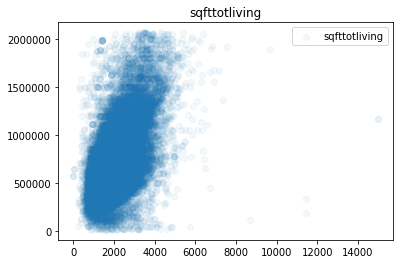

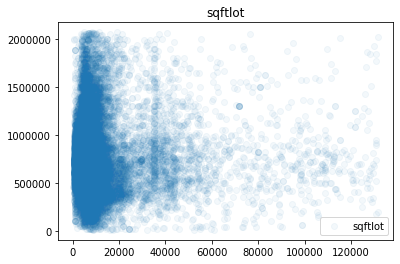

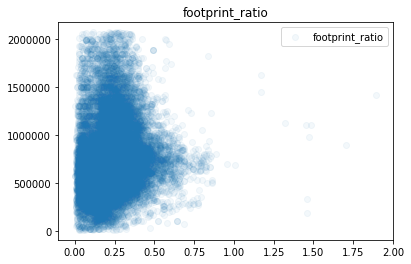

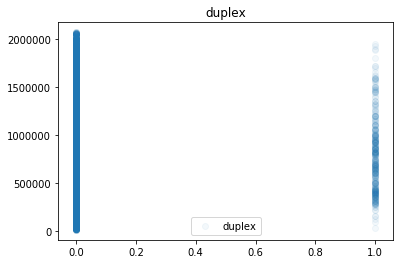

In [15]:
check_feature_linearity(baseline_features, x, y)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py

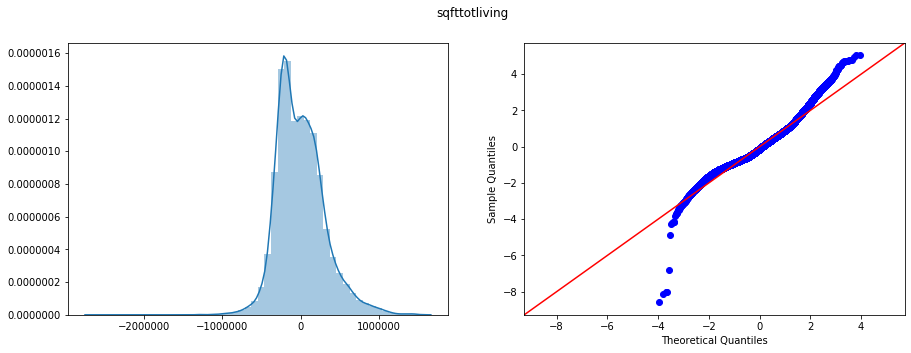

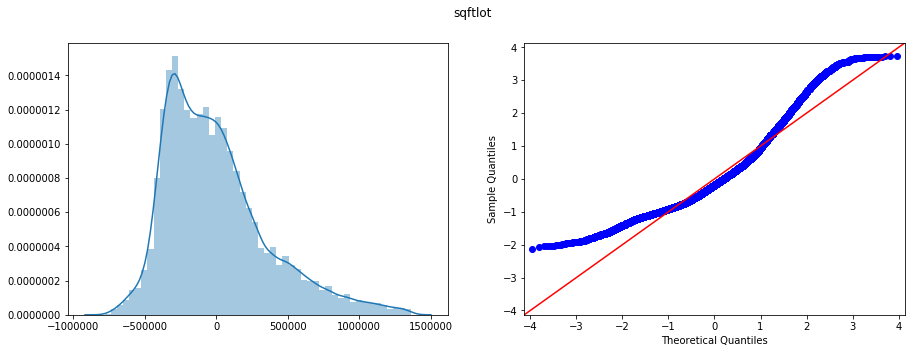

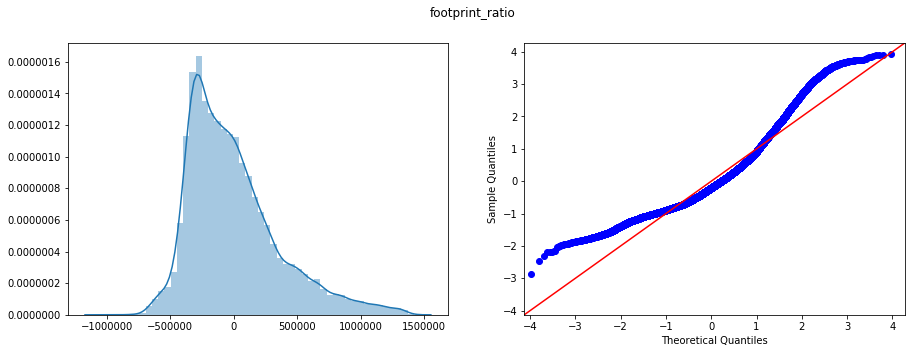

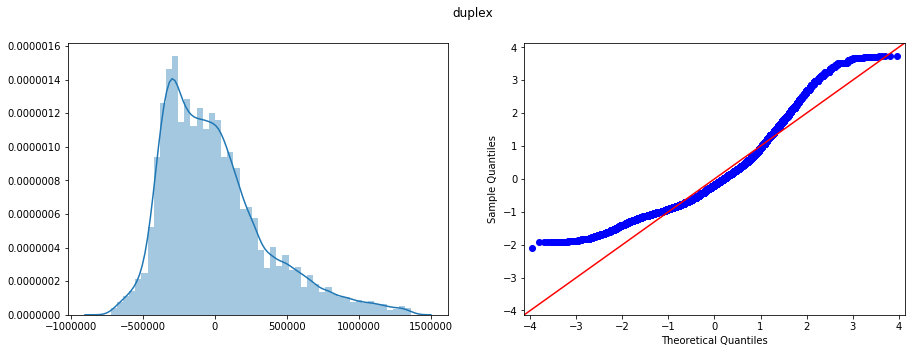

In [16]:
check_feature_resid_dist(baseline_features, x, y)

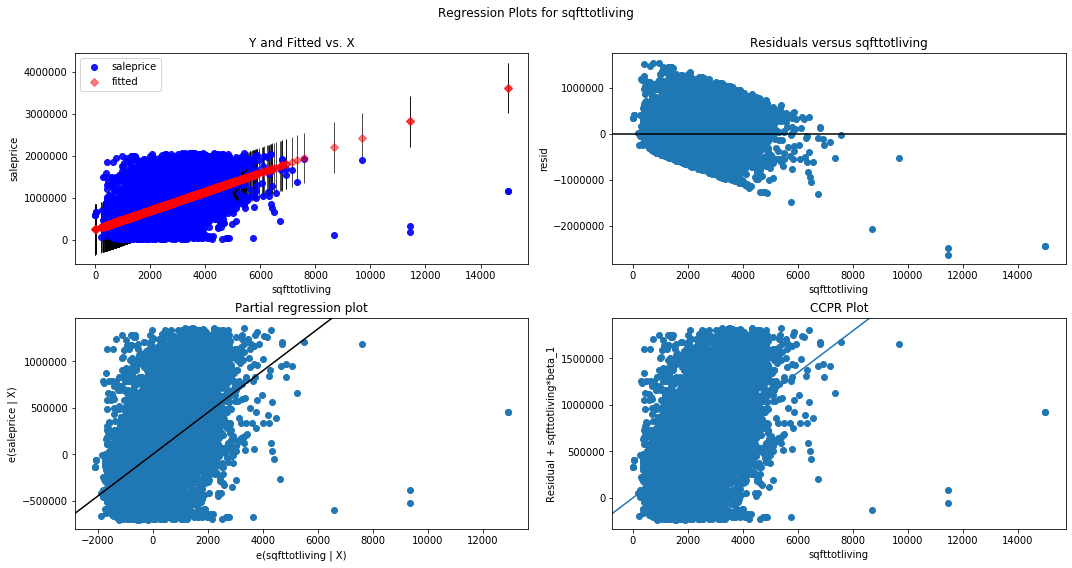

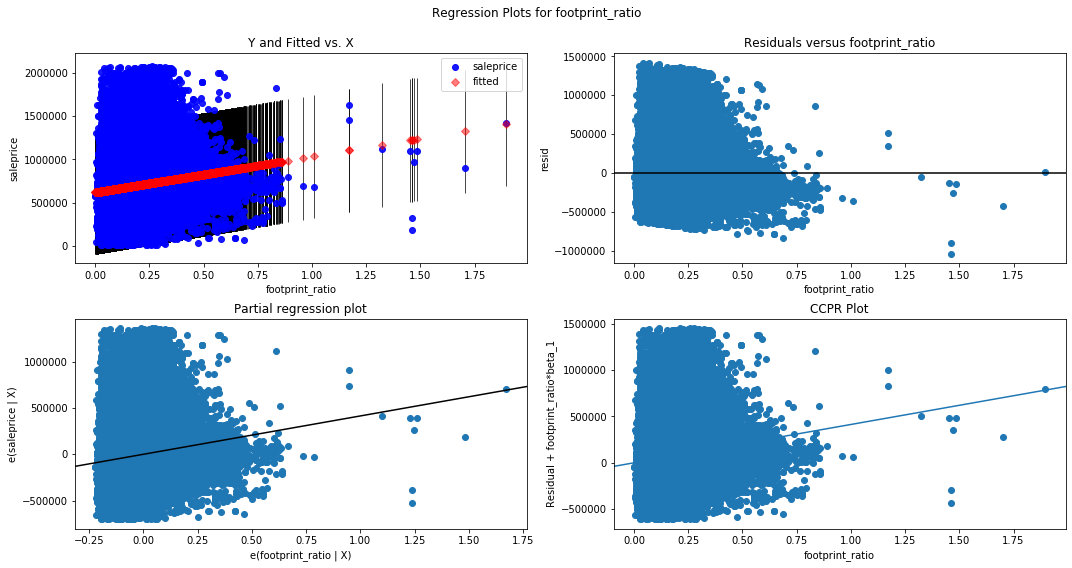

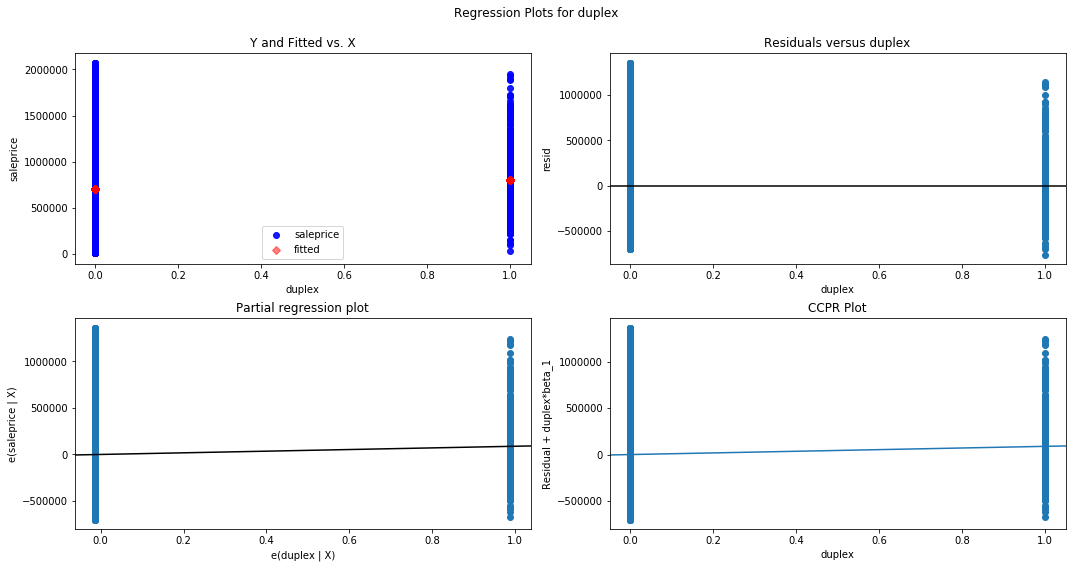

In [21]:
check_feature_heteros(baseline_features, x, y)

## Because The sqftlot seems to violoate assumption of linearity, lets remove it from the model

In [22]:
baseline_features = ['sqfttotliving','footprint_ratio','duplex']
make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     4110.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:53:26   Log-Likelihood:            -3.9388e+05
No. Observations:               28048   AIC:                         7.878e+05
Df Residuals:                   28044   BIC:                         7.878e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.868e+05   5493.038     34.008      0.000    1.76e+05    1.98e+05
sqfttotliving     221.4126      2.064    107.256      0.000     217.366     225.459
footprint_ratio  2.843e+05   1.47e+04     19.394      0.000    2.56e+05    3.13e+05
duplex           7.137e+04   1.64e+04      4.360      0.000    3.93e+04    1.03e+05
==============================================================================
Omnibus:                     3034.096   Durbin-Watson:                   0.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7990.036
Skew:                           0.617   Prob(JB):                         0.00
Kurtosis:                       5.305   Cond. No.                     2.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## What about including total bathrooms?

In [81]:
#engineer total baths

def engineer_total_baths(df):
    df['bath_total_count']=df['bathhalfcount']+df['bath3qtrcount']+df['bathfullcount']
    df.drop(columns = ['bathhalfcount','bath3qtrcount','bathfullcount'], inplace = True)
    return df

In [24]:
x = engineer_total_baths(x)
list_of_feat =['bath_total_count', 'sqfttotliving','footprint_ratio','duplex']
make_housing_model(list_of_feat,x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     3084.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:53:27   Log-Likelihood:            -3.9388e+05
No. Observations:               28048   AIC:                         7.878e+05
Df Residuals:                   28043   BIC:                         7.878e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.826e+05   5759.064     31.709      0.000    1.71e+05    1.94e+05
bath_total_count  7110.2462   2937.921      2.420      0.016    1351.779    1.29e+04
sqfttotliving      215.8321      3.095     69.740      0.000     209.766     221.898
footprint_ratio   2.746e+05   1.52e+04     18.070      0.000    2.45e+05    3.04e+05
duplex             7.11e+04   1.64e+04      4.344      0.000     3.9e+04    1.03e+05
==============================================================================
Omnibus:                     3011.641   Durbin-Watson:                   0.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7656.346
Skew:                           0.623   Prob(JB):                         0.00
Kurtosis:                       5.236   Cond. No.                     2.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

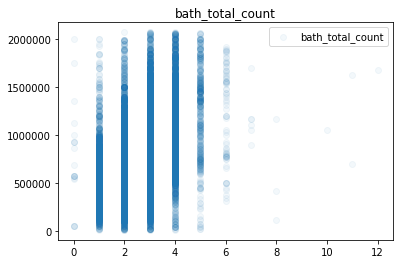

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


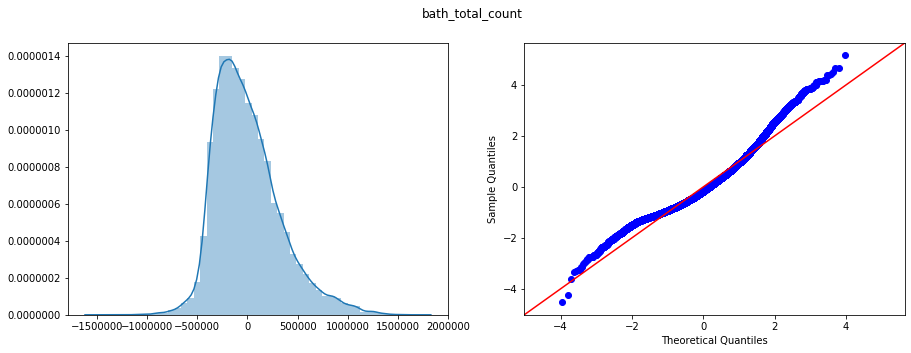

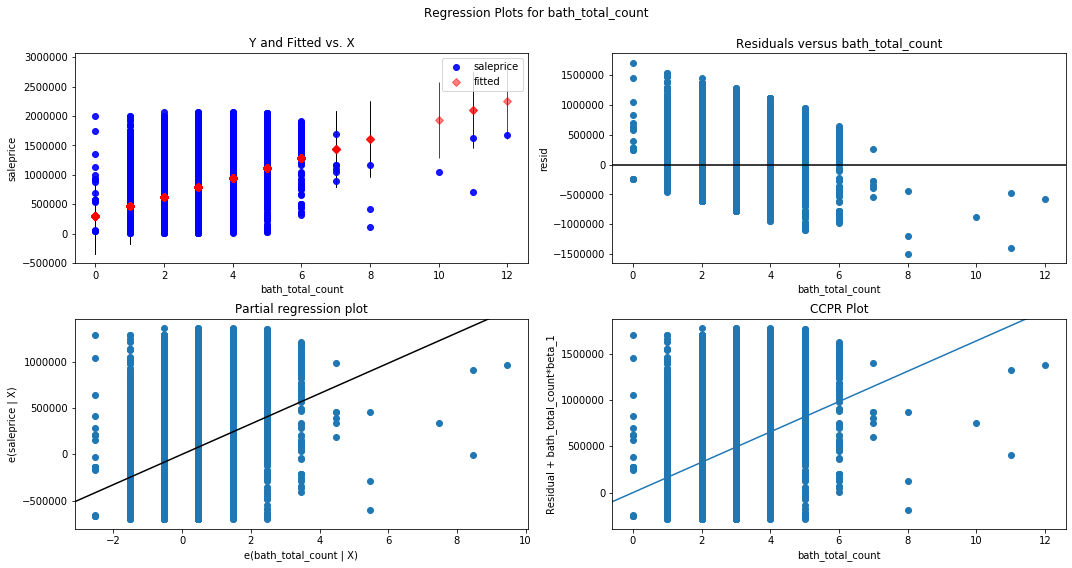

In [39]:
#total bathrooms adds a very slight bump to the R^2 value, lets test its assumptions:
check_feature_linearity(['bath_total_count'],x, y)
check_feature_resid_dist(['bath_total_count'],x, y)
check_feature_heteros(['bath_total_count'],x, y)

## What about age of house?

In [26]:
#engineer age:
x['age']=2019 - x['yrbuilt']
x.drop(columns = ['yrbuilt'], inplace = True)

In [27]:
list_of_feat =['bath_total_count','sqfttotliving','footprint_ratio','duplex', 'age']
make_housing_model(list_of_feat,x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     2755.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:53:41   Log-Likelihood:            -3.9339e+05
No. Observations:               28048   AIC:                         7.868e+05
Df Residuals:                   28042   BIC:                         7.868e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.734e+04   9221.766     -5.133      0.000   -6.54e+04   -2.93e+04
bath_total_count  4.467e+04   3122.480     14.307      0.000    3.86e+04    5.08e+04
sqfttotliving      216.3434      3.041     71.136      0.000     210.382     222.304
footprint_ratio   4.399e+05   1.58e+04     27.801      0.000    4.09e+05    4.71e+05
duplex           -2571.7042   1.63e+04     -0.158      0.874   -3.44e+04    2.93e+04
age               2302.8656     72.916     31.583      0.000    2159.947    2445.784
==============================================================================
Omnibus:                     3283.484   Durbin-Watson:                   0.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11173.587
Skew:                           0.587   Prob(JB):                         0.00
Kurtosis:                       5.860   Cond. No.                     2.17e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

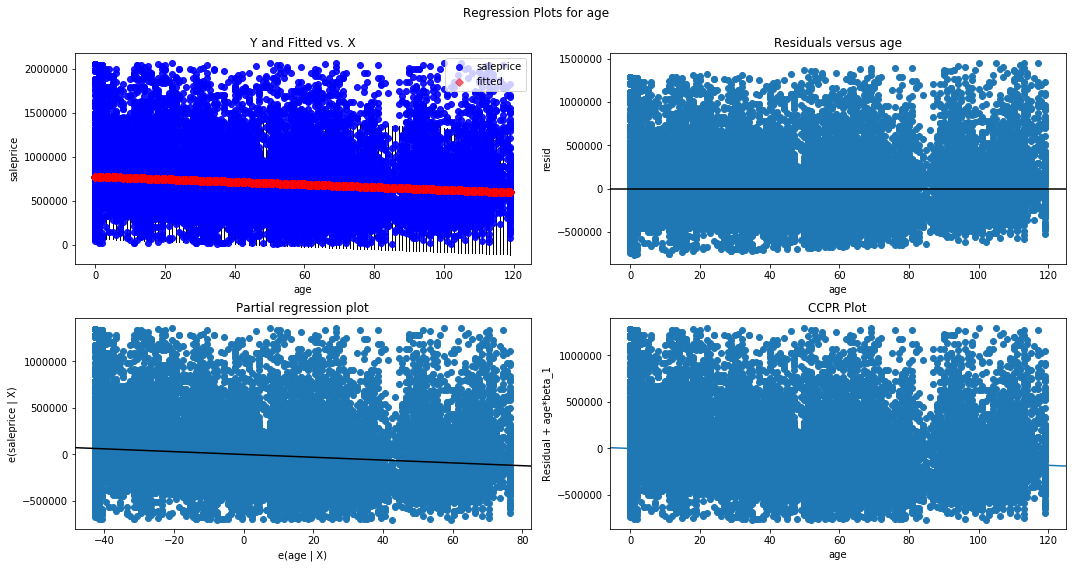

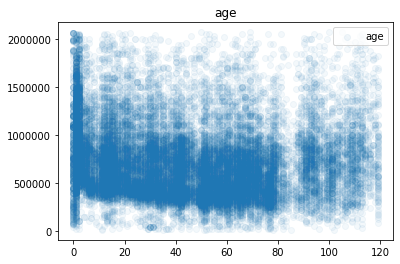

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


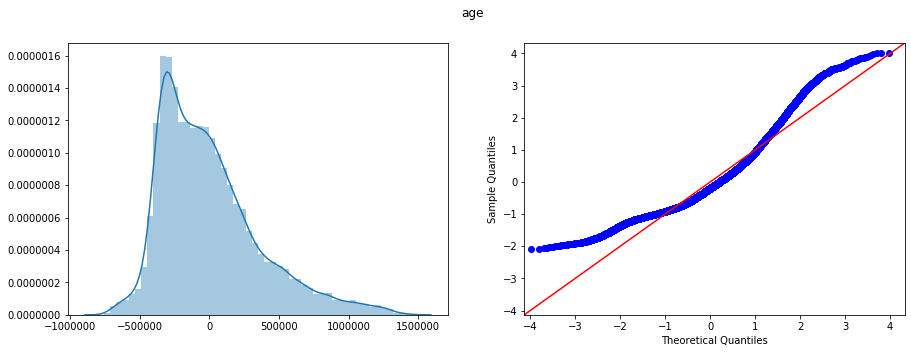

In [29]:
#age seems to add a notible boost in the model, lets test its assumptions:
check_feature_heteros(['age'],x,y)
check_feature_linearity(['age'],x,y)
check_feature_resid_dist(['age'],x,y)

It appears that age violates the assumption of linearity, so although it adds some strength to out R^2 value, we will leave it out of our improved model. 

## What about porches/decks?

In [34]:
#engineer total porch space
x['porch_sqft_total']=x['sqftopenporch']+x['sqftenclosedporch']
x.drop(columns = ['sqftopenporch','sqftenclosedporch'], inplace = True)

In [40]:
list_of_feat =['bath_total_count','sqfttotliving','footprint_ratio','duplex', 'porch_sqft_total']
make_housing_model(list_of_feat,x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     2474.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:01:46   Log-Likelihood:            -3.9387e+05
No. Observations:               28048   AIC:                         7.877e+05
Df Residuals:                   28042   BIC:                         7.878e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.848e+05   5774.579     32.000      0.000    1.73e+05    1.96e+05
bath_total_count  7283.9786   2936.992      2.480      0.013    1527.332     1.3e+04
sqfttotliving      211.4295      3.227     65.522      0.000     205.105     217.754
footprint_ratio   2.761e+05   1.52e+04     18.176      0.000    2.46e+05    3.06e+05
duplex            7.202e+04   1.64e+04      4.401      0.000    3.99e+04    1.04e+05
porch_sqft_total    80.2237     16.723      4.797      0.000      47.446     113.002
==============================================================================
Omnibus:                     2992.431   Durbin-Watson:                   0.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7638.792
Skew:                           0.618   Prob(JB):                         0.00
Kurtosis:                       5.238   Cond. No.                     2.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

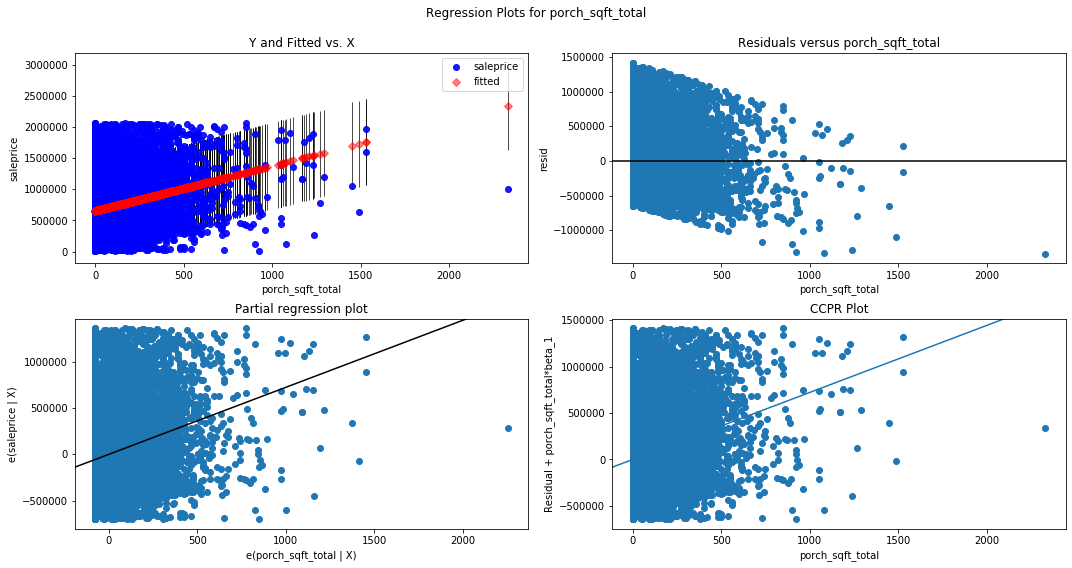

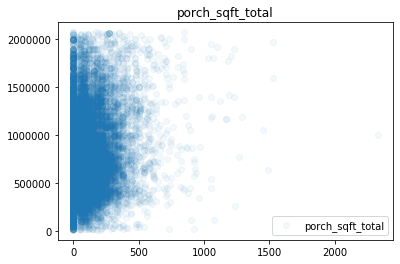

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


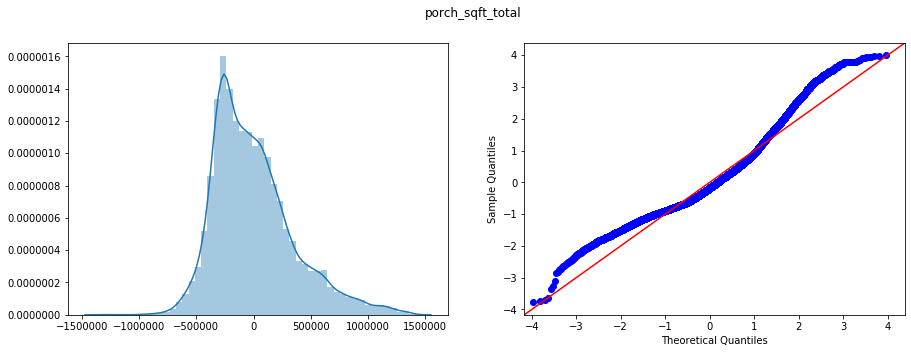

In [44]:
#the porch area feature seems to add a slight boost to our R^2 value, lets test its assumptions:
check_feature_heteros(['porch_sqft_total'],x,y)
check_feature_linearity(['porch_sqft_total'],x,y)
check_feature_resid_dist(['porch_sqft_total'],x,y)

Once again, it seems the porch space violates the assumption of linearity, so we will not include it in our final model. 

## How about zipcode? 

In [48]:
dropped_rows = x[x['zipcode'].str.contains ('98')]
dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])


dropped_rows['zipcode'] = pd.Categorical(dropped_rows['zipcode'])
df_zip = pd.get_dummies(dropped_rows['zipcode'], prefix = 'zip')

df_with_zip_cols = dropped_rows.join(df_zip, how = 'inner')




/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [108]:
def zip_code_df(df):
    """
    This function produces a tuple with tuple[0] as a df with the one hot encoded zip code features and tuple[1] as 
    the list of zip code column names. 
    
    The df input should be the dataframe that is output by the "clean_data_initial" function (not a dataframe that 
    the "saleprice" column has been removed from.. this is because we drop rows that do not have a zipcode so we need to 
    keep the shape of the dependent and independent variable dataframes equal). 
    
    """
    #drop the sales that do not include a zip code. We use '98' here to find king county specific zip codes and 
    #we select only the first 5 digits of the zip code because some sales' zip codes have an extraneious 4 digits
    dropped_rows = df[df['zipcode'].str.contains ('98')]
    dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])

    #use pd.Categorical and pd.get_dummies methods to one hot encode the zip codes
    dropped_rows['zipcode'] = pd.Categorical(dropped_rows['zipcode'])
    df_zip = pd.get_dummies(dropped_rows['zipcode'], prefix = 'zip')
    
    #drop one column from the zip code columns to address the inherent multicoliniearity
    df_zip.drop(columns = 'zip_98000', inplace = True) 
    
    #get a list of zipcode column names to include in model
    list_of_zips = df_zip.columns
    
    #join the zip code dataframe to the dataframe with the other predicitive features
    df_with_zip_cols = dropped_rows.join(df_zip, how = 'inner')
    
    
    return df_with_zip_cols, list_of_zips

def make_zipcode_model(df_clean, list_of_baseline_features):
    #call zip_code_df function to produce zip code df and list of zipcodes
    zip_tuple = zip_code_df(df_clean)

    #add on total bath colum using previously used function
    df = engineer_total_baths(zip_tuple[0])
    
    #add on list of other baseline features to the zip code list to put into model
    list_of_features = list(zip_tuple[1])
    list_of_features.extend(list_of_baseline_features)
    
    #produce the model
    
    return make_housing_model(list_of_features, df, df['saleprice'])



In [109]:
#create model with zipcodes and other baseline features

list_of_feat =['bath_total_count','sqfttotliving','footprint_ratio','duplex']
make_zipcode_model(df_clean)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     573.9
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:28:53   Log-Likelihood:            -3.1373e+05
No. Observations:               23014   AIC:                         6.276e+05
Df Residuals:                   22928   BIC:                         6.283e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.122e+05   2.02e+05      3.528      0.000    3.17e+05    1.11e+06
zip_98001        -7.015e+05   2.02e+05     -3.473      0.001    -1.1e+06   -3.06e+05
zip_98002        -6.793e+05   2.02e+05     -3.362      0.001   -1.08e+06   -2.83e+05
zip_98003        -6.823e+05   2.02e+05     -3.377      0.001   -1.08e+06   -2.86e+05
zip_98004         1.426e+05   2.03e+05      0.704      0.481   -2.54e+05     5.4e+05
zip_98005        -1.098e+04   2.03e+05     -0.054      0.957   -4.08e+05    3.86e+05
zip_98006        -1.309e+05   2.02e+05     -0.648      0.517   -5.27e+05    2.65e+05
zip_98007        -2.249e+05   2.03e+05     -1.110      0.267   -6.22e+05    1.72e+05
zip_98008        -2.364e+05   2.02e+05     -1.169      0.242   -6.33e+05     1.6e+05
zip_98009        -6.517e+05   2.85e+05     -2.284      0.022   -1.21e+06   -9.23e+04
zip_98010        -5.754e+05   2.03e+05     -2.838      0.005   -9.73e+05   -1.78e+05
zip_98011        -4.322e+05   2.02e+05     -2.136      0.033   -8.29e+05   -3.57e+04
zip_98014        -5.109e+05   2.03e+05     -2.520      0.012   -9.08e+05   -1.14e+05
zip_98019        -5.363e+05   2.02e+05     -2.649      0.008   -9.33e+05    -1.4e+05
zip_98022        -6.683e+05   2.02e+05     -3.306      0.001   -1.06e+06   -2.72e+05
zip_98023        -6.956e+05   2.02e+05     -3.444      0.001   -1.09e+06      -3e+05
zip_98024        -4.813e+05   2.04e+05     -2.362      0.018   -8.81e+05   -8.19e+04
zip_98027        -3.382e+05   2.02e+05     -1.673      0.094   -7.34e+05     5.8e+04
zip_98028        -4.584e+05   2.02e+05     -2.267      0.023   -8.55e+05   -6.21e+04
zip_98029        -2.542e+05   2.02e+05     -1.257      0.209   -6.51e+05    1.42e+05
zip_98030        -6.647e+05   2.02e+05     -3.289      0.001   -1.06e+06   -2.69e+05
zip_98031        -6.585e+05   2.02e+05     -3.259      0.001   -1.05e+06   -2.62e+05
zip_98032        -6.711e+05   2.02e+05     -3.318      0.001   -1.07e+06   -2.75e+05
zip_98033         2087.3538   2.02e+05      0.010      0.992   -3.94e+05    3.98e+05
zip_98034        -3.367e+05   2.02e+05     -1.667      0.095   -7.33e+05    5.91e+04
zip_98038        -6.129e+05   2.02e+05     -3.035      0.002   -1.01e+06   -2.17e+05
zip_98039         4.452e+05   2.08e+05      2.136      0.033    3.67e+04    8.54e+05
zip_98040         1.375e+05   2.02e+05      0.680      0.497   -2.59e+05    5.34e+05
zip_98042        -6.599e+05   2.02e+05     -3.268      0.001   -1.06e+06   -2.64e+05
zip_98045        -4.538e+05   2.02e+05     -2.246      0.025    -8.5e+05   -5.77e+04
zip_98047        -6.991e+05   2.04e+05     -3.435      0.001    -1.1e+06      -3e+05
zip_98050        -4.592e+05   2.33e+05     -1.971      0.049   -9.16e+05   -2493.516
zip_98051        -6.091e+05   2.05e+05     -2.964      0.003   -1.01e+06   -2.06e+05
zip_98052        -2.309

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,saleprice,propertytype,principaluse,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,...,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98224,zip_98288,zip_98354,zip_98422
0,310000.0,3.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
3,500000.0,3.0,6.0,3.0,0,0,0,0,18.0,8.0,...,0,0,0,0,0,0,0,0,0,0
6,456800.0,11.0,6.0,3.0,0,0,0,0,1.0,8.0,...,1,0,0,0,0,0,0,0,0,0
7,461000.0,11.0,6.0,3.0,0,0,0,0,1.0,8.0,...,1,0,0,0,0,0,0,0,0,0
8,80000.0,1.0,6.0,3.0,0,0,0,0,1.0,7.0,...,0,0,1,0,0,0,0,0,0,0
13,795000.0,10.0,6.0,3.0,0,0,0,0,1.0,8.0,...,1,0,0,0,0,0,0,0,0,0
15,440000.0,3.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0,0,1,0,0,0,0,0,0,0
16,520000.0,3.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
17,166166.0,3.0,6.0,15.0,0,0,0,0,18.0,8.0,...,0,0,0,0,0,0,0,0,0,0
20,97500.0,3.0,6.0,24.0,0,0,0,0,18.0,8.0,...,0,0,0,0,0,0,0,0,0,0


LOCATION LOCATION LOCATION wow, that added a bunch to our R^2! Lets check the assumptions: 

In [155]:
def check_zip_code_res_normality(df):
    zip_tuple = zip_code_df(df)
    zip_list = list(zip_tuple[1])
    zip_list.append('saleprice')
    zip_res = zip_tuple[0][zip_list]
    
    lookup_dict = {}
    for col in zip_res.columns:
        
        try:
            index = int(col[-3:])
            search_string = col[-3:]
            amount = int(zip_res[zip_res[col]== True]['saleprice'].mean())
            span = float(zip_res[zip_res[col]== True]['saleprice'].std())
            lookup_dict[col] = (amount, span)
        except:
            continue



    error_list = []       
    for col in zip_res.columns:
        try:
            df_filtered = zip_res[zip_res[col]== True]
            amount = df_filtered['saleprice'].mean()
            span = float(df_filtered['saleprice'].std())
            df_filtered['sigma_difference'] = (df_filtered['saleprice'] - amount)/span
            a = list(df_filtered['sigma_difference'])
            error_list.extend(a)


        except:
            continue  
            
     
    info = list(filter(lambda x: np.abs(x)> 0, error_list))

    return sns.distplot(info)
    
    

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

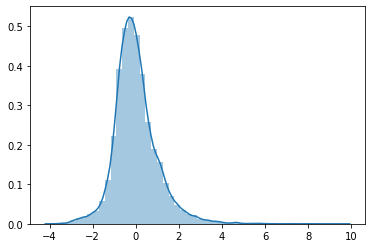

In [156]:
check_zip_code_res_normality(df_clean)
